In [1]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os

In [2]:
fig_dir = Path('/home/jovyan/Figures/ECCO_GMSL/')

### Confirm Existence of .netrc file in your home directory

In [3]:
# make a .netrc file in your home directory with the following
# machine urs.earthdata.nasa.gov login ifenty password XCfK5QhgEGuWVgu4qRuH
# for login and password use your EarthData login

# if this command returns 1, you are good

In [4]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [5]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [6]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2023-08-07 23:11:51+00:00.



# Define important params

In [7]:
# ECCO Starts on Jan 1, 1992
ECCO_start_time= np.datetime64('1992-09-23')
alongtrack_file_dir = Path('/home/jovyan/Data/ECCO_GMSL')

# SIC dir
sic_dir=Path('/home/jovyan/Data/ECCO_GMSL/SIC_ECCO_DAILY_V4R4B/')

# output directory
output_dir_nonoise=Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output')
output_dir=Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise')
output_dir.mkdir(exist_ok=True)

In [7]:
std_randomerror=0.03

# Load the ECCO spatial mean 1992-2017

In [8]:
ecco_mean = xr.open_dataset(str(alongtrack_file_dir) + '/ECCO_V4r4_mean_SSH.nc')
ecco_mean

<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Data variables:
    mean_ssh   (latitude, longitude) float32 ...

# Find the x,y points for each of the cycle days

## Load the AlongTrack x,y,t file

In [9]:
alongtrack = xr.open_dataset(str(alongtrack_file_dir) + '/AlongTrack_sample.nc', decode_times=False)
alongtrack

<xarray.Dataset>
Dimensions:   (i: 602812)
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 ... 602807 602808 602809 602810 602811
Data variables:
    time      (i) int64 ...
    y         (i) float32 ...
    x         (i) float32 ...
    orbit_nb  (i) int16 ...

## Create a dictionary with x,y points for each of the 10 cycle days

In [10]:
print(alongtrack.time.min())
print(alongtrack.time.max())
print(len(alongtrack.time))

<xarray.DataArray 'time' ()>
array(0)
<xarray.DataArray 'time' ()>
array(856657)
602812


In [11]:
np.min(alongtrack.y)

<xarray.DataArray 'y' ()>
array(-66.14912, dtype=float32)

In [12]:
x_track_in_d = {}
y_track_in_d = {}

alongtrack_swath = {}
tc = 0
all_ins = []
for d in range(10):
    d_start = d*86400
    d_end = d_start + 86400
    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]
    
    all_ins.append(ins) 
    x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])
    
    print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')
    
    tc = tc + len(ins)
    # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
    alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])

cycle day: 0, time_start 0s, time_end 86400s, number of xy points 59523
cycle day: 1, time_start 86400s, time_end 172800s, number of xy points 60551
cycle day: 2, time_start 172800s, time_end 259200s, number of xy points 61022
cycle day: 3, time_start 259200s, time_end 345600s, number of xy points 60572
cycle day: 4, time_start 345600s, time_end 432000s, number of xy points 61407
cycle day: 5, time_start 432000s, time_end 518400s, number of xy points 60498
cycle day: 6, time_start 518400s, time_end 604800s, number of xy points 60235
cycle day: 7, time_start 604800s, time_end 691200s, number of xy points 60658
cycle day: 8, time_start 691200s, time_end 777600s, number of xy points 60949
cycle day: 9, time_start 777600s, time_end 864000s, number of xy points 57397


In [13]:
# sanity check the range of xy points 
for d in range(10):
    print(f'cycle day {d} min and max longitudes: \
        {np.nanmin(x_track_in_d[d].values), np.nanmax(x_track_in_d[d].values)}')

cycle day 0 min and max longitudes:         (-179.99864, 179.99623)
cycle day 1 min and max longitudes:         (-179.9978, 179.99731)
cycle day 2 min and max longitudes:         (-179.99812, 179.99065)
cycle day 3 min and max longitudes:         (-179.99268, 179.99953)
cycle day 4 min and max longitudes:         (-179.9971, 179.9989)
cycle day 5 min and max longitudes:         (-179.99747, 179.99992)
cycle day 6 min and max longitudes:         (-179.99892, 179.99971)
cycle day 7 min and max longitudes:         (-179.99136, 179.9993)
cycle day 8 min and max longitudes:         (-179.98524, 179.99416)
cycle day 9 min and max longitudes:         (-179.99942, 179.99695)


# Prepare ECCO Daily SSH dataset

In [14]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

In [15]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

# ummc = response.json()['items'][0]
# ccid = ummc['meta']['concept-id']
# print(f'collection id: {ccid}')

## Make a "direct connection" to the S3 file system

In [16]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [17]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Make a list of all of the ECCO SSH dataset files for some arbitrary year

In [18]:
import time

In [19]:
year = 1992

start_time = time.time()

ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
print(f'time to find urls: { time.time() - start_time} s')

pprint(ECCO_SSH_files[0:5])
print('...')
pprint(ECCO_SSH_files[-5:])

time to find urls: 5.547060966491699 s
['podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-01_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-02_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-03_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-04_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-05_ECCO_V4r4b_latlon_0p50deg.nc']
...
['podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-12-27_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-12-28_ECCO_V4r4b_latlon_0p50deg.nc',
 'podaac-ops-cumulus-protected/ECCO_L4_S

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

Note: this takes a minute.

In [20]:
for year in range(1992,2018):#1992,2018
    
    start_time = time.time()
    ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
    paths=[fs.open(f) for f in ECCO_SSH_files]
    
    ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
    )
    ECCO_DS_daily.close()

    # Load SIC files
    ECCO_SIC_files = list(sic_dir.glob('*'+ str(year) + '*.nc'))
    ECCO_SIC_files=np.sort(ECCO_SIC_files)
    ECCO_SIC_daily = xr.open_mfdataset(
        paths=ECCO_SIC_files,
        combine='nested',
        concat_dim='time',
        compat='override',
        decode_cf=True,
        coords='minimal',
        chunks={'time': 1}  
    )
    ECCO_DS_daily=ECCO_DS_daily.where(ECCO_SIC_daily.SIarea <= 0) #change to NaN everything that is False

    ECCO_SSH = ECCO_DS_daily.SSH-ecco_mean.mean_ssh
    ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
    ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)
    
    # Loop through all days
    for f in range(len(ECCO_SSH.time)):

        # get the date/time associated with this record
        rec_time = ECCO_SSH.time.dt.floor("D")[f]

        # Determine which cycle day we're in
        # ... count how many days since ecco start time?
        delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)
        if delta_days>=0:
            # Determine which GSFC cycle it is
            cycle = int(np.floor(delta_days / 10)+1)

            # ... cycle day is delta_days mod 10
            cycle_day = delta_days % 10

            # print(f'record day of year {str(rec_time.values)[0:10]}, cycle day {cycle_day}')

            # sample the ECCO field at the x,y locations for this cycle day 
            # search within a 200 km radius for the nearest neighbor.
            # (overkill since it's a 1 degree model but just to be safe)

            ECCO_at_xy_points =\
                kd_tree.resample_nearest(ECCO_grid_def, \
                                         ECCO_SSH[f].values, \
                                         alongtrack_swath[cycle_day],\
                                         radius_of_influence=200000, fill_value = np.nan)

            #add random noise to the alongtrack array, mu=0, std=3cm (0.03m)
            ECCO_at_xy_points = ECCO_at_xy_points+np.random.normal(0,std_randomerror,len(ECCO_at_xy_points))

            # make a new DataArray object
            ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points, dims=['i'])
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle':cycle})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
            ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
            ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since '+str(ECCO_start_time)
            ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'
            ECCO_at_xy_points_da.cycle.attrs['comment'] = 'Total cycle since '+str(ECCO_start_time)

            ECCO_at_xy_points_da.name = 'SSH_at_xy'
            ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'

            # Save to Disk
            new_fname = 'ECCO_V4r4_alongtrack_SSH_' + str(rec_time.values).split('T')[0] + '_randomnoise.nc'
            ECCO_at_xy_points_da.to_netcdf(output_dir / new_fname)

    print(year, time.time() - start_time, cycle)

2008 200.83661150932312 595
2009 212.14830660820007 631
2010 217.38863706588745 668
2011 221.53138160705566 704
2012 220.06313061714172 741
2013 219.4096438884735 777
2014 221.16834926605225 814
2015 223.79035067558289 850
2016 226.84062099456787 887
2017 229.40762734413147 924


# ECCO_at_xy_points_da

# Plot 10 days of along track SSH

In [8]:
year=1992
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))
ECCO_alongtrack_files_nonoise = np.sort(list(output_dir_nonoise.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))

In [9]:
tmp = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp.append(xr.open_dataset(ECCO_alongtrack_files[d]))
    print(ECCO_alongtrack_files[d])

/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-23_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-24_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-25_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-26_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-27_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-28_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-29_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_randomnoise/ECCO_V4r4_alongtrack_SSH_1992-09-30_randomnoise.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack

In [10]:
tmp2 = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp2.append(xr.open_dataset(ECCO_alongtrack_files_nonoise[d]))
    print(ECCO_alongtrack_files_nonoise[d])

/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-23.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-24.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-25.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-26.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-27.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-28.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-29.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-09-30.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-10-01.nc
/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-10-02.nc


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


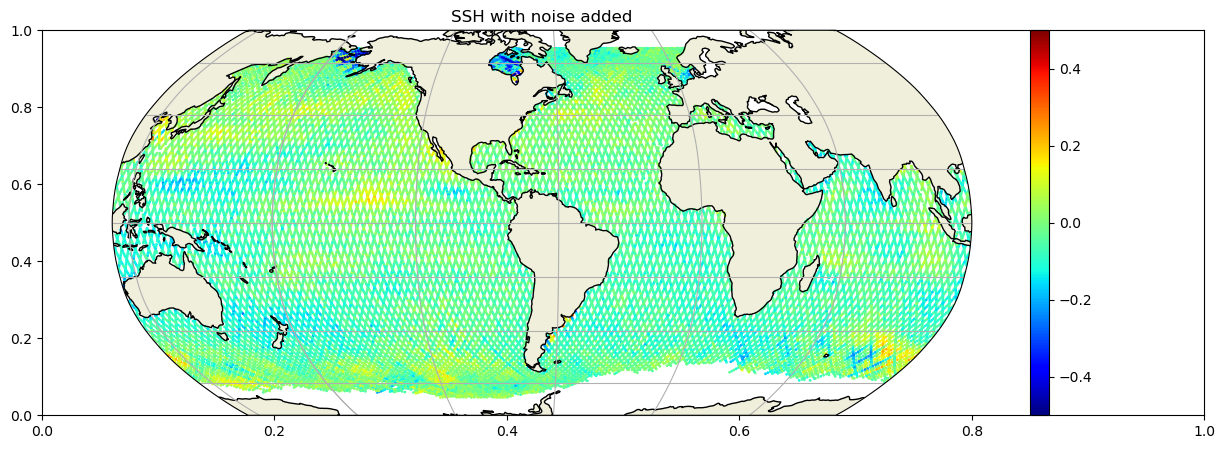

In [11]:
#Plot cycle 1 starting 1992/09/23

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')
    ax.set_title('SSH with noise added')
plt.colorbar(p)


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


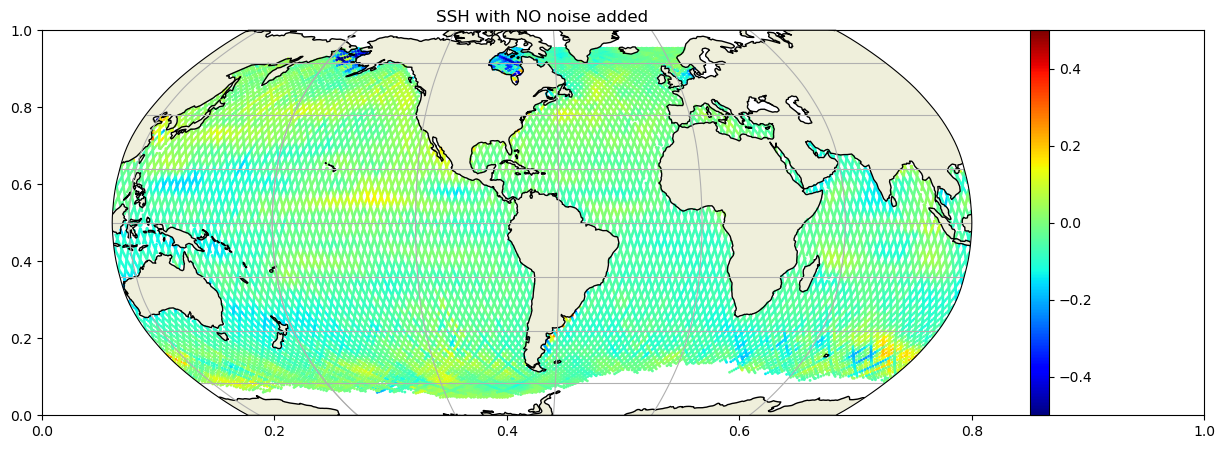

In [12]:
#Plot cycle 1 starting 1992/09/23 WITH NO NOISE

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp2[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.5,vmax=0.5, cmap='jet')  
    ax.set_title('SSH with NO noise added')
plt.colorbar(p)

adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


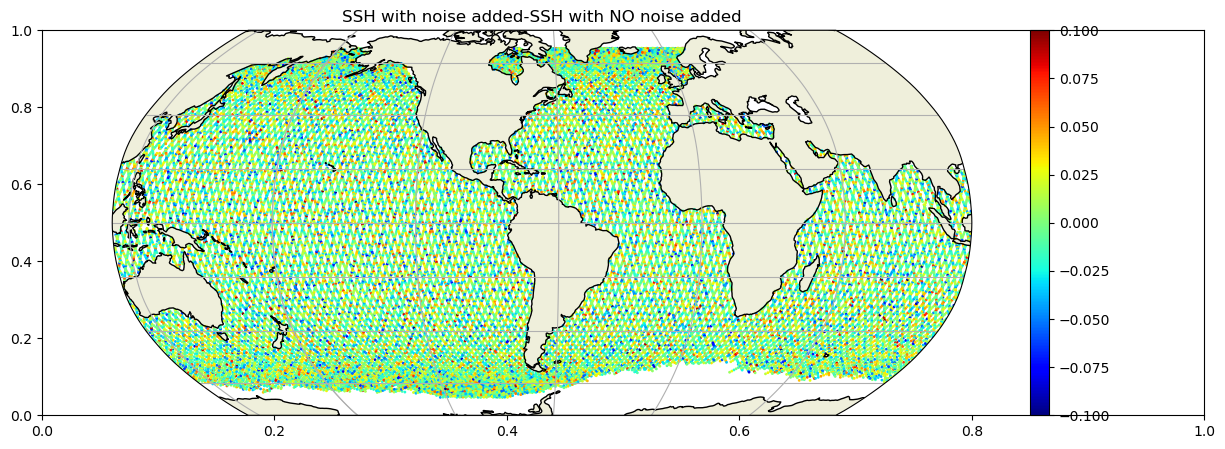

In [13]:
#Plot cycle 1 starting 1992/09/23 WITH NOISE MINUS NO NOISE

fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy2 = tmp2[d].SSH_at_xy
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy2[::kk]-ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-0.1,vmax=0.1, cmap='jet')
    ax.set_title('SSH with noise added-SSH with NO noise added')
plt.colorbar(p)

/tmp/ipykernel_897/3540873297.py:36: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)
/tmp/ipykernel_897/3540873297.py:38: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


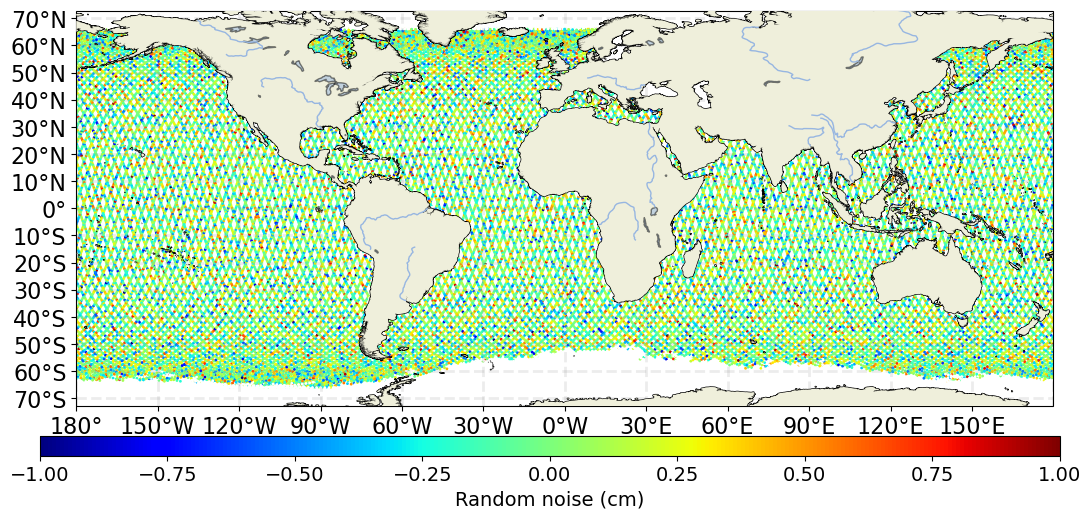

In [20]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
for d in range(10):
    ECCO_at_xy2 = tmp2[d].SSH_at_xy
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')
    pp = plt.scatter(ECCO_at_xy.lon[::kk],ECCO_at_xy.lat[::kk],c=(ECCO_at_xy2[::kk]-ECCO_at_xy[::kk])*100, s=1,cmap=palette,vmin=-1,vmax=1,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('Random noise (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_randomnoise.png',dpi=200,transparent=False,facecolor='white')